# Install

In [1]:
!pip install livelossplot

# Setup

In [2]:
from torch.utils.data import Dataset

import torch
import pickle
import os
import pandas as pd
import numpy as np
import traceback
from pathlib import Path
from livelossplot import PlotLossesKeras

# You are not allowed to use DataLoader, torch.nn, torch.functional, torchvision
# Backpropagation and data preprocessing must be implemented from scratch
# Check https://github.com/Tensor-Reloaded/AI-Learning-Hub/blob/main/how_to/use_kaggle.md for learning how to use kaggle and submit to this competition

# Data aquisition

## Preprocesing functions

In [3]:

def normalization_n1_p1(x):
    return (x/127.5)-1

def normalization_n0_p1(x):
    return x/255

def one_hot(y, num_classes=1):
    #print(y.shape, y)
    tmp = torch.zeros((y.size(0), num_classes), dtype=torch.float32)
    tmp[torch.arange(y.size(0)), y] = 1.0
    return tmp


## Summary function

In [4]:

def test_dataset_fn(img, label):
    info_str = """img: shape {}, min {}, max {}, type {};
label: shape {}, min {}, max {}, type {};""".format(img.shape, torch.min(img), torch.max(img), type(img),
                                           label.shape, torch.min(label), torch.max(label), type(label))
    print(info_str)

## Dataset

In [5]:

class ExtendedMNISTDataset(Dataset):
    def __init__(self, root: str = "/kaggle/input/fii-atnn-2025-competition-1", train: bool = True):
        """ExtendedMNISTDataset:
        root  - path root of dataset
        train - read train or test dataset (true - train, false - test)
        preprocessing - image preprocesing function
        Dataset structure:
            list -> (batchsize, tuple -> (np.array -> (image->(784, )), scalar -> (labels->1)))
        """
        # select filename
        if (train):
            file = "extended_mnist_train.pkl"
        else:
            file = "extended_mnist_test.pkl"
        # join root to filename
        filename = os.path.join(root, file)
        # read dataset
        dataset = self.__read(filename)
        self.inputs, self.outputs = self.__split_data(dataset)

    def __read(self, filename):
        # try to open filename
        try:
            f = open(filename, "rb")
            try:
                dataset = pickle.load(f)
            except Exception as e:
                dataset = None
                self.__show_exception(e)
            finally:
                f.close()
        except IOError as e:
            dataset = None
            self.__show_exception(e)
        return dataset

    def __show_exception(self, e) -> None:
        tb = traceback.extract_tb(e.__traceback__)
        last_call = tb[-1]
        print(f"❌ Error in function '{last_call.name}' at line {last_call.lineno}")
        print(f"   File: {last_call.filename}")
        print(f"   Exception: {e}")

    def __split_data(self, dataset):
        inputs  = []
        outputs = []
        for input, ouput in dataset:
            inputs.append(input)
            outputs.append(ouput)
        return np.array(inputs, dtype=np.uint8), np.array(outputs, dtype=np.int32)

    def __len__(self, ) -> int:
        return self.inputs.shape[0]

    def __getitem__(self, i : int):# int|np array
        return self.inputs[i], self.outputs[i]


In [135]:
#
train_ds = ExtendedMNISTDataset(root="/content", train=True)

In [136]:
train_ds[[0, 1, 2]]

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([2, 6, 2], dtype=int32))

In [137]:
len(train_ds)

60000

In [138]:
_, y = train_ds[np.arange(len(train_ds))]

In [139]:
y.max()

np.int32(9)

## DataLoader

In [6]:

class DataLoader(object):
    def __init__(self, dataset, batchsize=1, shuffle=False):
        assert (batchsize > 0), "batchsize should be ghreat than 'zero'"
        assert (isinstance(shuffle, bool)), "shuffle should be 'bool'"
        self.dataset = dataset
        self.batchsize = batchsize
        self.shuffle = shuffle
        self.size = len(self.dataset)
        # shufle
        if (self.shuffle):
            self.permutation = np.random.permutation(self.size)
        else:
            self.permutation = np.arange(self.size, dtype=np.int32)
        self.maps_fn = []

    def __len__(self) -> int:
        return len(self.dataset)//self.batchsize

    def __call__(self):
        try:
            for i in range(0, self.size, self.batchsize):
                pos  = self.permutation[i:i+self.batchsize]
                datas = self.dataset[pos]
                if (isinstance(datas, tuple)):
                    datas = [torch.from_numpy(data) for data in datas]
                else:
                    datas = torch.from_numpy(datas)
                datas = self.__map_fn(datas)
                yield datas
            else:
                if (self.shuffle):
                    self.permutation = np.random.permutation(self.size)
        except Exception as e:
            self.__show_exception(e)

    def take(self, size):
        try:
            for i, data in zip(range(size), self()):
                yield data
            else:
                pass
        except Exception as e:
            self.__show_exception(e)

    def __show_exception(self, e) -> None:
        tb = traceback.extract_tb(e.__traceback__)
        last_call = tb[-1]
        print(f"❌ Error in function '{last_call.name}' at line {last_call.lineno}")
        print(f"   File: {last_call.filename}")
        print(f"   Exception: {e}")

    def map(self, fn):
        self.maps_fn.append(fn)

    def __map_fn(self, data):
        for fn in self.maps_fn:
            data = fn(*data)
        return data

In [88]:
dataloader = DataLoader(train_ds, batchsize=20, shuffle=False)

In [89]:
dataloader.map(lambda x, y: (normalization_n1_p1(x), one_hot(y, num_classes=10)))
dataloader.map(lambda x, y: (x.unsqueeze(-1), y.unsqueeze(-1)))

In [90]:
for img, label in dataloader.take(100):
    test_dataset_fn(img, label)
    #print(label)

img: shape torch.Size([20, 784, 1]), min -1.0, max 1.0, type <class 'torch.Tensor'>;
label: shape torch.Size([20, 10, 1]), min 0.0, max 1.0, type <class 'torch.Tensor'>;
img: shape torch.Size([20, 784, 1]), min -1.0, max 1.0, type <class 'torch.Tensor'>;
label: shape torch.Size([20, 10, 1]), min 0.0, max 1.0, type <class 'torch.Tensor'>;
img: shape torch.Size([20, 784, 1]), min -1.0, max 1.0, type <class 'torch.Tensor'>;
label: shape torch.Size([20, 10, 1]), min 0.0, max 1.0, type <class 'torch.Tensor'>;
img: shape torch.Size([20, 784, 1]), min -1.0, max 1.0, type <class 'torch.Tensor'>;
label: shape torch.Size([20, 10, 1]), min 0.0, max 1.0, type <class 'torch.Tensor'>;
img: shape torch.Size([20, 784, 1]), min -1.0, max 1.0, type <class 'torch.Tensor'>;
label: shape torch.Size([20, 10, 1]), min 0.0, max 1.0, type <class 'torch.Tensor'>;
img: shape torch.Size([20, 784, 1]), min -1.0, max 1.0, type <class 'torch.Tensor'>;
label: shape torch.Size([20, 10, 1]), min 0.0, max 1.0, type <cla

# Optimizer

In [7]:
"""
A module to implement the stochastic gradient descent learning
algorithm for a feedforward neural network.  Gradients are calculated
using backpropagation.
"""

class SGD(object):

    def __init__(self, parameters, lr):
        """
        parameters - a list of parameters for every layer
                    -> list of parameters
                        -> one element of parameter is list of torch tensor
        lr - learning rate
        """
        self.__parameters = parameters
        self.__lr = lr

    def __call__(self, grads):
        """
        grads - a list of grads for every layer
                    -> list of grads for parameters
                        -> one element of grads is list of torch tensor
        """
        #print("____optimizer____")
        #print("list layers: parameter {}, size {}, grad {}, size {}".format(type(self.__parameters), len(self.__parameters), type(grads), len(grads)))
        for l_parameters, l_grads in zip(self.__parameters, grads):
            #print("list: parameters {}, grads {}".format(type(l_parameters), type(l_grads)))
            if ((l_grads is not None)):
                for parameter, grad in zip(l_parameters, l_grads):
                    #print("parameter {}, grad {}".format(parameter.shape, grad.shape))
                    #batch_size = grad.size(0)
                    #grad = grad.sum(dim=0, keepdim=False)
                    #grad = torch.div(grad, batch_size, out=grad)
                    #print("parameter {}, grad {}".format(parameter.shape, grad.shape))
                    torch.sub(parameter, grad, alpha=self.__lr, out=parameter)



# Build Metrics

## Build MetricsList

In [8]:

class MetricsList(object):
    def __init__(self, metrics_fn):
        """"""
        if (metrics_fn is not None):
            if (isinstance(metrics_fn, (dict))):
                for key in metrics_fn.keys():
                    if (not isinstance(metrics_fn[key], Metrics)):
                        raise NameError("The metric: '{}' is type '{}' not as 'Metrics' object".format(key, type(metrics_fn[key])))
            else:
                raise NameError("The argument need to be as 'Dict' object, but is '{}'".format(type(metrics_fn)))
        else:
            pass
        #
        self.__metrics_fn = metrics_fn

    def __call__(self, y, y_pred):
        logs = {}
        if (self.__metrics_fn is not None):
            for key in self.__metrics_fn.keys():
                metric = self.__metrics_fn[key](y, y_pred)
                logs[key] = metric
        return logs


## Build Metrics

In [9]:

class Metrics(object):
    def __init__(self, name=""):
        """"""
        self.name = name

    def __call__(self, y_pred, y):
        pass


In [10]:

class Acuracy(Metrics):
    def __init__(self, **kw):
        super().__init__(**kw)
        pass

    def __call__(self, y_pred, y):
        # y_pred: logits or probabilities (batch_size, num_classes)
        # y_true: true labels (batch_size,)
        preds = torch.argmax(y_pred, dim=1)
        y     = torch.argmax(y,      dim=1)
        correct = (preds == y).sum().item()
        total = y.size(0)
        return correct / total


# Build Callback

## Build CallbacksList

In [11]:

class CallbacksList(object):
    def __init__(self, callbacks):
        """"""
        if (callbacks is not None):
            if (isinstance(callbacks, list)):
                    for i, callback in enumerate(callbacks, 0):
                        if (not isinstance(callback, (type(Callbacks()), type(PlotLossesKeras())))):
                            raise NameError("The callback: '{}' is type '{}' not as 'Callbacks' object".format(i, type(callback)))
            else:
                raise NameError("The argument need to be as 'List' object, but is '{}'".format(type(callbacks)))
        else:
            callbacks = []
        #
        self.__callbacks = callbacks

    def on_batch_begin(self, batch, logs=None):
        for callback in self.__callbacks:
            callback.on_batch_begin(batch, logs)

    def on_batch_end(self, batch, logs=None):
        for callback in self.__callbacks:
            callback.on_batch_end(batch, logs)

    def on_epoch_begin(self, epoch, logs=None):
        for callback in self.__callbacks:
            callback.on_epoch_begin(epoch, logs)

    def on_epoch_end(self, epoch, logs=None):
        for callback in self.__callbacks:
            callback.on_epoch_end(epoch, logs)

    def on_predict_batch_begin(self, batch, logs=None):
        for callback in self.__callbacks:
            callback.on_predict_batch_begin(batch, logs)

    def on_predict_batch_end(self, batch, logs=None):
        for callback in self.__callbacks:
            callback.on_predict_batch_end(batch, logs)

    def on_predict_begin(self, logs=None):
        for callback in self.__callbacks:
            callback.on_predict_begin(logs)

    def on_predict_end(self, logs=None):
        for callback in self.__callbacks:
            callback.on_predict_end(logs)

    def on_test_batch_begin(self, batch, logs=None):
        for callback in self.__callbacks:
            callback.on_test_batch_begin(batch, logs)

    def on_test_batch_end(self, batch, logs=None):
        for callback in self.__callbacks:
            callback.on_test_batch_end(batch, logs)

    def on_test_begin(self, logs=None):
        for callback in self.__callbacks:
            callback.on_test_begin(logs)

    def on_test_end(self, logs=None):
        for callback in self.__callbacks:
            callback.on_test_end(logs)

    def on_train_batch_begin(self, batch, logs=None):
        for callback in self.__callbacks:
            callback.on_train_batch_begin(batch, logs)

    def on_train_batch_end(self, batch, logs=None):
        for callback in self.__callbacks:
            callback.on_train_batch_end(batch, logs)

    def on_train_begin(self, logs=None):
        for callback in self.__callbacks:
            callback.on_train_begin(logs)

    def on_train_end(self, logs=None):
        for callback in self.__callbacks:
            callback.on_train_end(logs)


## Build Callbacks

In [12]:

class Callbacks(object):
    def __init__(self,):
        """"""
        pass

    def on_batch_begin(self, batch, logs=None):
        pass

    def on_batch_end(self, batch, logs=None):
        pass

    def on_epoch_begin(self, epoch, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        pass

    def on_predict_batch_begin(self, batch, logs=None):
        pass

    def on_predict_batch_end(self, batch, logs=None):
        pass

    def on_predict_begin(self, logs=None):
        pass

    def on_predict_end(self, logs=None):
        pass

    def on_test_batch_begin(self, batch, logs=None):
        pass

    def on_test_batch_end(self, batch, logs=None):
        pass

    def on_test_begin(self, logs=None):
        pass

    def on_test_end(self, logs=None):
        pass

    def on_train_batch_begin(self, batch, logs=None):
        pass

    def on_train_batch_end(self, batch, logs=None):
        pass

    def on_train_begin(self, logs=None):
        pass

    def on_train_end(self, logs=None):
        pass


# Build Layers

## Build Layer

In [13]:

class Layer(object):
    def __init__(self, name="layer"):
        torch.set_grad_enabled(False) # do not use pythorch gradient
        self.name = name
        self.__parameters = []
        self.__grads = None
        self.__is_derivable = False

    def set_is_derivable(self, bVal):
        self.__is_derivable = bVal

    def set_grads(self, grads):
        self.__grads = grads

    def is_derivable(self):
        return self.__is_derivable

    def get_grads(self):
        return self.__grads

    def _init_param(self, shape, init_fn):
        if (init_fn is not None):
            x = init_fn(shape)
        else:
            # init like glorot uniform
            lim = np.sqrt(6/np.sum(shape))
            x = torch.empty(*shape).uniform_(-lim, lim)
        self.__parameters.append(x)
        return x

    def backward(self, x):
        raise NameError("Layer {}: The method 'backward' is not implemented".format(self.name))

    def get_prime(self, features):
        return None

    def get_weights(self):
        return None

    def parameters(self):
        return self.__parameters

    def copy(self):
        copy_params = []
        for param in self.__parameters:
            c_param = torch.empty(param.size(), dtype=torch.float32)
            c_param.copy_(param, non_blocking=False)
            copy_params.append(c_param)
        return copy_params

    def cmp(self, parameters: list):
        is_equal = True
        print("layer {}, size: loc {}, par {}".format(self.name, len(self.__parameters), len(parameters)))
        for loc_parameters, c_parameters in zip(self.__parameters, parameters):
            is_equal = is_equal and torch.allclose(loc_parameters, c_parameters)
        return is_equal

    def __call__(self, x):
        raise NameError("Layer {}: The method '__call__' is not implemented".format(self.name))


In [186]:
test_l = Layer(name="test")

## Build Input layer

In [14]:

class InputLayer(Layer):
    def __init__(self, **kw):
        super().__init__(**kw)
        self.set_is_derivable(False)

    def backward(self, delta, features):
        self.set_grads(None)

    def get_prime(self, features):
        return None

    def get_weights(self):
        return None

    def __call__(self, x):
        return x


## Build Dense layer

In [19]:

class Dense(Layer):
    def __init__(self, in_size, out_size, init_fn=None, use_bias=False, init_fn_b=None, **kw):
        super().__init__(**kw)
        self.__use_bias = use_bias
        self.__w = self._init_param((out_size, in_size), init_fn)
        if (self.__use_bias):
            self.__b = self._init_param((out_size, 1), init_fn_b)
        self.set_is_derivable(False)

    def backward(self, delta, features):
        # get batch size
        batch_size = features.size(0)
        # calculate bias gradients
        if (self.__use_bias):
            nabla_b = delta.sum(dim=0)
            torch.div(nabla_b, batch_size, out=nabla_b)
            #print("----nabla_b", nabla_b.shape)
        # perform dimensions
        features = features.transpose(-1, -2)
        #print("----delta", delta.shape)
        #print("----features", features.shape)
        # calculate weight gradients
        nabla_w = torch.matmul(delta, features)# w = D*Ft
        grad_w = nabla_w.sum(dim=0)
        torch.div(grad_w, batch_size, out=grad_w)
        #print("----nabla_w", nabla_w.shape)
        # set gradients
        grads = [grad_w]
        if (self.__use_bias):
            grads.append(nabla_b)
        self.set_grads(grads)
        del nabla_w
        # Empty cached memory
        torch.cuda.empty_cache()

    def get_prime(self, features):
        return None

    def get_weights(self):
        return self.__w

    def __call__(self, x):
        x = torch.matmul(self.__w.unsqueeze(0), x)
        if (self.__use_bias):
            x = torch.add(x, self.__b)
        return x


In [69]:

batch_size = 2
delta    = torch.empty(batch_size, 10, 1).uniform_(-1, 1)
features = torch.empty(batch_size, 100, 1).uniform_(-1, 1)

features = features.transpose(-1, -2)
# calculate weight gradients
torch.matmul(delta, features).sum(dim=0).shape

torch.Size([10, 100])

In [86]:

batch_size = 2
w = torch.empty(batch_size, 100, 784).uniform_(-1, 1)
x = torch.empty(batch_size, 784, 1).uniform_(-1, 1)

# calculate weight gradients
torch.matmul(w, x).shape

torch.Size([2, 100, 1])

In [25]:

class Dense(Layer):
    def __init__(self, in_size, out_size, init_fn=None, use_bias=False, init_fn_b=None, **kw):
        super().__init__(**kw)
        self.__use_bias = use_bias
        self.__w = self._init_param((in_size, out_size), init_fn)
        if (self.__use_bias):
            self.__b = self._init_param((out_size, ), init_fn_b)
        self.set_is_derivable(False)

    def backward(self, delta, features):
        # get batch size
        batch_size = features.size(0)
        # calculate bias gradients
        if (self.__use_bias):
            nabla_b = delta.sum(dim=0)
            torch.div(nabla_b, batch_size, out=nabla_b)
            #print("----nabla_b", nabla_b.shape)
        # perform dimensions
        features = features.transpose(1, 0)
        #print("----delta", delta.shape)
        #print("----features", features.shape)
        # calculate weight gradients
        nabla_w = torch.matmul(features, delta)# w = Ft*D
        torch.div(nabla_w, batch_size, out=nabla_w)
        #print("----nabla_w", nabla_w.shape)
        # set gradients
        grads = [nabla_w]
        if (self.__use_bias):
            grads.append(nabla_b)
        self.set_grads(grads)

    def get_prime(self, features):
        return None

    def get_weights(self):
        return self.__w

    def __call__(self, x):
        x = torch.matmul(x, self.__w)
        if (self.__use_bias):
            x = torch.add(x, self.__b)
        return x


In [15]:

    def backward(self, delta, features):
        batch_size = features.size(0)
        #delta    = delta.unsqueeze(1)
        features = features.transpose(1, 0)
        #print("----delta", delta.shape)
        #print("----features", features.shape)

        nabla_w = torch.matmul(features, delta)# w = Ft*D
        torch.div(nabla_w, batch_size, out=nabla_w)
        #print("----nabla_w", nabla_w.shape)
        nabla_b = delta.sum(dim=0)
        torch.div(nabla_b, batch_size, out=nabla_b)
        #print("----nabla_b", nabla_b.shape)
        grads = [nabla_w, nabla_b]
        self.set_grads(grads)
    """
    def backward(self, delta, features):
        # get batch size
        batch_size = features.size(0)
        # calculate nabla for bias
        if (self.__use_bias):
            nabla_b = delta.sum(dim=0)
            torch.div(nabla_b, batch_size, out=nabla_b)
            #print("----nabla_b", nabla_b.shape)
        # prepare dimensions
        delta    = delta.unsqueeze(1)
        features = features.unsqueeze(-1)
        #print("----delta", delta.shape)
        #print("----features", features.shape)

        nabla_w = torch.bmm(features, delta)
        nabla_w = nabla_w.sum(dim=0)
        torch.div(nabla_w, batch_size, out=nabla_w)
        #print("----nabla_w", nabla_w.shape)
        grads = [nabla_w]
        if (self.__use_bias):
            grads.append(nabla_b)
        self.set_grads(grads)
    """

'\ndef backward(self, delta, features):\n    # get batch size\n    batch_size = features.size(0)\n    # calculate nabla for bias\n    if (self.__use_bias):\n        nabla_b = delta.sum(dim=0)\n        torch.div(nabla_b, batch_size, out=nabla_b)\n        #print("----nabla_b", nabla_b.shape)\n    # prepare dimensions\n    delta    = delta.unsqueeze(1)\n    features = features.unsqueeze(-1)\n    #print("----delta", delta.shape)\n    #print("----features", features.shape)\n    \n    nabla_w = torch.bmm(features, delta)\n    nabla_w = nabla_w.sum(dim=0)\n    torch.div(nabla_w, batch_size, out=nabla_w)\n    #print("----nabla_w", nabla_w.shape)\n    grads = [nabla_w]\n    if (self.__use_bias):\n        grads.append(nabla_b)\n    self.set_grads(grads)\n'

In [27]:
tmp_x = torch.empty(3, 20).uniform_(-1, 1)  # Uniform [-1, 1]
tmp_x = torch.ones(2, 3, 20)  # Uniform [-1, 1]
print(tmp_x)

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1.]]])


In [28]:
dense_l = Dense(in_size=20, out_size=3, use_bias=True)

In [29]:
dense_l(tmp_x)

tensor([[[ 1.1257, -1.0865, -1.1252],
         [ 1.1257, -1.0865, -1.1252],
         [ 1.1257, -1.0865, -1.1252]],

        [[ 1.1257, -1.0865, -1.1252],
         [ 1.1257, -1.0865, -1.1252],
         [ 1.1257, -1.0865, -1.1252]]])

In [23]:
dense_l.backward(1)

TypeError: Dense.backward() missing 1 required positional argument: 'features'

## Build Relu layer

In [16]:

class Relu(Layer):
    def __init__(self, min=0, **kw):
        super().__init__(**kw)
        self.__min = torch.tensor(min)
        self.set_is_derivable(True)

    def backward(self, delta, features):
        self.set_grads(None)

    def get_prime(self, features):
        return (features > 0).float()

    def get_weights(self):
        return None

    def __call__(self, x):
        x = torch.maximum(x, self.__min)
        return x


In [31]:
tmp_x = torch.empty(3, 20).uniform_(-1, 1)  # Uniform [-1, 1]
#tmp_x = torch.ones(2, 3, 20)  # Uniform [-1, 1]
print(tmp_x)

tensor([[-0.2147,  0.7854,  0.6982,  0.7165,  0.9628, -0.0168, -0.7561, -0.0126,
         -0.0143,  0.2169,  0.4241, -0.5057, -0.4185,  0.0529,  0.4176,  0.7627,
          0.2612, -0.9293, -0.8287,  0.1271],
        [ 0.0707,  0.9269, -0.8177,  0.3035, -0.4018,  0.1338, -0.4901, -0.1726,
          0.5371, -0.8540, -0.5457,  0.8025, -0.3467, -0.2213, -0.4189, -0.5081,
          0.8426,  0.9289,  0.8051,  0.2765],
        [ 0.4647,  0.5800, -0.9863, -0.9222, -0.1540, -0.9986,  0.4406,  0.7460,
          0.9229, -0.0899,  0.8097,  0.3678, -0.8543, -0.0504,  0.9877,  0.0411,
          0.2094, -0.5094,  0.6172, -0.0490]])


In [32]:
relu_l = Relu(min=0)

In [33]:
relu_l(tmp_x).shape

torch.Size([3, 20])

In [34]:
relu_l.get_prime().shape

TypeError: Relu.get_prime() missing 1 required positional argument: 'features'

## Build softmax layer

In [17]:

class Softmax(Layer):
    def __init__(self, **kw):
        super().__init__(**kw)
        self.set_is_derivable(True)

    def backward(self, delta, features):
        self.set_grads(None)
    """
    def get_prime(self, features):
        # Suppose softmax over channel dim
        x = self(features)
        x_flat = x.reshape(-1, x.shape[-1])  # collapse batch*H*W into one dimension
        # batch matrix multiplication
        x_bmm = torch.bmm(x_flat.unsqueeze(2), x_flat.unsqueeze(1))
        jacobian = torch.diag_embed(x_flat) - x_bmm
        jacobian = jacobian.sum(dim=-1, keepdim=False)
        return jacobian
    """

    def get_prime(self, features):
        # Suppose softmax over channel dim
        x = self(features)
        diff = torch.sub(1, x, alpha=1, out=None)
        x = torch.mul(x, diff, out=x)
        return x

    def get_weights(self):
        return None

    def __call__(self, x):
        x = torch.exp(x) - torch.max(x)
        x = torch.div(x, torch.sum(x), rounding_mode=None, out=None)
        return x


In [36]:
tmp_x = torch.empty(3, 20).uniform_(-1, 1)  # Uniform [-1, 1]
#tmp_x = torch.ones(2, 3, 20)  # Uniform [-1, 1]
print(tmp_x)

tensor([[-0.2362,  0.4914, -0.5989,  0.5817, -0.1990, -0.4743, -0.4052, -0.5721,
          0.0346, -0.3257,  0.3997,  0.9869, -0.1369,  0.8468,  0.2440,  0.3187,
         -0.3427, -0.2786, -0.9753, -0.3535],
        [-0.1218,  0.8696,  0.6346,  0.7159, -0.5462, -0.9119,  0.3980, -0.8161,
          0.9467,  0.3217,  0.0708,  0.0147, -0.8290,  0.4878,  0.3823, -0.3581,
          0.4144,  0.1264,  0.9421,  0.5322],
        [ 0.3252, -0.3648, -0.1405,  0.1632,  0.5896,  0.5241,  0.5790,  0.4439,
          0.2877, -0.9869, -0.6017, -0.8320, -0.1324,  0.5844,  0.8483, -0.0297,
         -0.5137, -0.4017, -0.3747, -0.6301]])


In [37]:
softmax_l = Softmax()

In [38]:
softmax_l(tmp_x)

tensor([[0.0111, 0.0230, 0.0077, 0.0251, 0.0115, 0.0087, 0.0094, 0.0079, 0.0145,
         0.0101, 0.0210, 0.0377, 0.0123, 0.0328, 0.0179, 0.0193, 0.0100, 0.0106,
         0.0053, 0.0099],
        [0.0124, 0.0335, 0.0265, 0.0287, 0.0081, 0.0056, 0.0209, 0.0062, 0.0362,
         0.0194, 0.0151, 0.0143, 0.0061, 0.0229, 0.0206, 0.0098, 0.0213, 0.0159,
         0.0360, 0.0239],
        [0.0194, 0.0098, 0.0122, 0.0165, 0.0253, 0.0237, 0.0251, 0.0219, 0.0187,
         0.0052, 0.0077, 0.0061, 0.0123, 0.0252, 0.0328, 0.0136, 0.0084, 0.0094,
         0.0097, 0.0075]])

In [84]:
softmax_l.get_prime().shape

torch.Size([3, 20, 20])

## Build sigmoid layer

In [18]:

class Sigmoid(Layer):
    def __init__(self, **kw):
        super().__init__(**kw)
        self.__t = torch.tensor(1.)
        self.set_is_derivable(True)

    def backward(self, delta, features):
        self.set_grads(None)

    def get_prime(self, features):
        # Suppose softmax over channel dim
        x = self(features)
        diff = torch.sub(self.__t, x, alpha=1, out=None)
        x = torch.mul(x, diff, out=x)
        return x

    def get_weights(self):
        return None

    def __call__(self, x):
        x = torch.exp(-x, out=x)
        x = torch.add(x, self.__t, alpha=1, out=x)
        x = torch.div(self.__t, x, out=x)
        return x


# Build Model

In [20]:
"""
A module to implement the stochastic gradient descent learning
algorithm for a feedforward neural network.  Gradients are calculated
using backpropagation.  Note that I have focused on making the code
simple, easily readable, and easily modifiable.  It is not optimized,
and omits many desirable features.
"""

class Model(object):
    def __init__(self, device):
        """"""
        self.__device = device
        self.__layers = []
        self.__parameteres  = []
        self.__out_features = []
        self.__metrics_fn = None

    def serialization(self, layers: list):
        if (isinstance(layers, list)):
            for i, layer in enumerate(layers, 0):
                if (not isinstance(layer, Layer)):
                    raise NameError("The layer: '{}' is not as 'Layer' object".format(i))
            self.__layers = layers
        else:
            raise NameError("The argument need to be as 'List' object, but is '{}'".format(type(layers)))

    def compile(self, optimizer, loss, metrics, callbacks):
        self.optimizer = optimizer
        self.loss_fn = loss
        self.metric_fn = MetricsList(metrics)
        self.callbacks = CallbacksList(callbacks)

    def backward(self, loss):
        layer = self.__layers[-1]
        delta = loss
        #print("layer {}, shape 'delta' {}".format(layer.name, delta.shape))
        if (layer.is_derivable()):
            prime_fn = self.__layers[-1].get_prime
            #print("layer {}, '{}'".format(layer.name, "derivable"))
        else:
            prime_fn = None
            # output of the second-last layer
            prev_features = self.__out_features[-2]
            features = self.__out_features[-1]
            # calculate the gradient for the cost function C_x
            delta = torch.empty(features.size(), dtype=torch.float32)
            delta = torch.add(delta, loss, alpha=1, out=delta)
            layer.backward(delta, prev_features)
            #print("layer {}, prev_layer '{}', D*Ft".format(layer.name, self.__layers[-2].name))

        #print("+++++++++++++++++++++++++++++++++++++++++")
        # backprop
        for l in range(2, len(self.__layers), 1):
            layer = self.__layers[-l]
            #print("layer {}, shape: 'delta' {}".format(layer.name, delta.shape))
            # -----------
            weights = self.__layers[-l+1].get_weights()
            if (weights is not None):
                #print("\tnext_layer {}, shape: 'weights' {}, 'delta' {}, D*Wt".format(self.__layers[-l+1].name, weights.shape, delta.shape))
                weights = weights.transpose(1, 0).unsqueeze(0)
                delta   = torch.matmul(weights, delta)
                #print("'weights' -l+1, shape {}".format(weights.shape))
                #print(" 'delta' -l, shape {}".format(delta.shape))
            else:
                #print("not 'weights' -l+1")
                #print(" 'delta' -l, shape {}".format(delta.shape))
                #print("\tnext_layer {} not 'weights', ".format(self.__layers[-l+1].name))
                pass

            # =========
            if (prime_fn is not None):
                # Derivative of the last layer
                # calculate gradients for layer -l
                features = self.__out_features[-l]
                prime = prime_fn(features)
                #print("\tnext_layer {}, shape: 'prime' {}, 'delta' {}, D*P".format(self.__layers[-l+1].name, prime.shape, delta.shape))
                delta = torch.mul(delta, prime)
                #print("'prime' -l+1, shape {}".format(prime.shape))
                #print(" 'delta' -l, shape {}".format(delta.shape))
            else:
                #print("not 'prime' -l+1")
                #print(" 'delta' -l, shape {}".format(delta.shape))
                #print("\tnext_layer {} not 'prime', ".format(self.__layers[-l+1].name))
                pass

            if (layer.is_derivable()):
                prime_fn = layer.get_prime
                #print("'derivable' -l {}".format(l))
                #print("layer {} 'derivable'".format(layer.name))
            else:
                prime_fn = None
                # calculate gradients for layer -l
                features = self.__out_features[-l-1]
                #print("'not derivable' -l, shape {}".format(features.shape))
                #print(" 'delta' -l, shape {}".format(delta.shape))
                layer.backward(delta, features)
                #print("layer {}, prev_layer {}, not 'derivable', D*Ft".format(layer.name, self.__layers[-l-1].name))
        #print("+++++++++++++++++++++++++++++++++++++++++")

    def get_grads(self):
        grads = []
        for layer in self.__layers:
            grads.append(layer.get_grads())
        return grads

    def parameters(self):
        parameteres = []
        for layer in self.__layers:
            parameteres.append(layer.parameters())
        return parameteres

    def forward(self, train_ds, test_ds=None, epochs=1):
        """Return the output of the network if ``a`` is input."""
        if (not isinstance(train_ds, DataLoader)):
            raise NameError("The train dataset: is type '{}' not as 'DataLoader' object".format(type(train_ds)))
        # start training
        self.callbacks.on_train_begin()
        for epoch in range(epochs):
            epoch_logs = self.train_batch(epoch, train_ds)
        self.callbacks.on_train_end(epoch_logs)
        return None

    def train_batch(self, epoch, train_ds):
        self.callbacks.on_epoch_begin(epoch)
        batch_logs = {}
        for i, data in zip(range(len(train_ds)), train_ds()):
        #for i, data in zip(range(1), train_ds()):
            self.callbacks.on_train_batch_begin(i)
            batch_logs = self.train_step(data)
            self.callbacks.on_train_batch_end(i, batch_logs)
            # Empty cached memory
            torch.cuda.empty_cache()
        self.callbacks.on_epoch_end(epoch, batch_logs)

    def train_step(self, data):
        img, y = data
        #print("type img {}".format(type(img)))
        img = img.to(self.__device)
        y   = y.to(self.__device)
        y_pred = self(img)
        #print("y_pred {}, y {}".format(y_pred.shape, y.shape))
        loss = self.loss_fn(y_pred, y)
        #print("loss {}, data @{}@".format(loss.shape, loss))
        metrics = self.metric_fn(y_pred, y)
        self.backward(loss)
        grads = self.get_grads()
        self.optimizer(grads)
        loss = torch.mean(loss)
        logs = {"loss":loss}
        logs.update(metrics)
        return logs


    def __call__(self, inputs):
        y = inputs
        #print("model: shape {}".format(y.shape))
        for layer in self.__layers:
            y = layer(y)
            #print("model: name {}, shape {}".format(layer.name, y.shape))
            self.__out_features.append(y)
        return y

    def copy(self):
        parameteres = []
        for layer in self.__layers:
            parameteres.append(layer.copy())
        return parameteres

    def cmp(self, m_parameters):
        is_equal = True
        for layer, l_parameters in zip(self.__layers, m_parameters):
            tmp_equal = layer.cmp(l_parameters)
            print("layer {}, cmp {}".format(layer.name, tmp_equal))
            is_equal = is_equal and tmp_equal
        return is_equal

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives partial C_x
        partial a for the output activations."""
        return (output_activations-y)


In [44]:
tmp_x = torch.ones(2, 3, 20)  # Uniform [-1, 1]
print(tmp_x)

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1.]]])


In [37]:
tmp_x.transpose(2, 1).shape

torch.Size([2, 20, 3])

# Train

In [21]:
# Pipiline
train_ds = ExtendedMNISTDataset(root="/content", train=True)
test_ds = ExtendedMNISTDataset(root="/content", train=False)
# Data loader
train_loader = DataLoader(train_ds, batchsize=32, shuffle=True)
train_loader.map(lambda x, y: (normalization_n1_p1(x), one_hot(y, num_classes=10)))
train_loader.map(lambda x, y: (x.unsqueeze(-1), y.unsqueeze(-1)))

test_loader  = DataLoader(test_ds,  batchsize=20, shuffle=False)
test_loader.map(lambda x, y: (normalization_n1_p1(x), one_hot(y, num_classes=10)))

In [22]:

if torch.accelerator.is_available():
    device=torch.accelerator.current_accelerator()
else:
    device = torch.device("cpu")
print(device)

cpu


In [23]:
import torch.nn.functional as F

In [24]:
def pyTorch_init(shape):
    lim = np.sqrt(1./shape[0])
    return torch.empty(*shape).uniform_(-lim, lim)

In [25]:
pyTorch_init((784, 100))

tensor([[ 3.0898e-02, -7.3493e-05, -2.7475e-02,  ...,  1.7356e-02,
         -8.7690e-03,  7.1056e-03],
        [-2.4226e-02, -7.5569e-03, -2.6560e-02,  ...,  1.6351e-02,
         -9.5651e-03,  3.0135e-02],
        [-1.1401e-02,  1.2495e-02, -2.3525e-02,  ..., -7.4247e-03,
         -3.1869e-02, -1.6953e-02],
        ...,
        [-4.0899e-03, -2.0507e-02,  2.1776e-02,  ..., -7.1401e-03,
         -1.6032e-02, -1.4364e-02],
        [-4.9581e-03, -1.9841e-02,  1.8665e-02,  ..., -3.1068e-02,
          5.9023e-03, -1.0430e-02],
        [ 3.2758e-02,  2.0944e-03, -1.3189e-03,  ..., -3.2962e-02,
         -1.8022e-02,  2.1517e-02]])

In [26]:

model = Model(device=device)
layers = [
    InputLayer(name="Inputs"),
    Dense(784, 100, init_fn=pyTorch_init, use_bias=True, init_fn_b=pyTorch_init, name="Dense_h1"),
    Relu(name="Relu_h0"),
    Dense(100, 10, init_fn=pyTorch_init, use_bias=True, init_fn_b=pyTorch_init, name="Dense_h2"),
    #Relu(name="Relu_h1"),
    #Dense(200, 100, init_fn=None, use_bias=False, init_fn_b=None, name="Dense_h2"),
    #Relu(name="Relu_h2"),
    #Dense(100, 10, init_fn=None, use_bias=False, init_fn_b=None, name="Dense_h3"),
    #Softmax(name="Softmax_out"),
    Sigmoid(name="sigmoid"),
]
model.serialization(layers)

In [27]:
c_model = model.copy()

In [28]:
model.cmp(c_model)

layer Inputs, size: loc 0, par 0
layer Inputs, cmp True
layer Dense_h1, size: loc 2, par 2
layer Dense_h1, cmp True
layer Relu_h0, size: loc 0, par 0
layer Relu_h0, cmp True
layer Dense_h2, size: loc 2, par 2
layer Dense_h2, cmp True
layer sigmoid, size: loc 0, par 0
layer sigmoid, cmp True


True

In [29]:
def cost_derivative(output_activations, y):
    """Return the vector of partial derivatives partial C_x
    partial a for the output activations."""
    return (output_activations-y)**2

In [30]:

cros_entropy = torch.nn.CrossEntropyLoss()
#cros_entropy = F.cross_entropy
optimizer = SGD(model.parameters(), lr=0.001)
plot_losses = PlotLossesKeras()
model.compile(
    optimizer=optimizer,
    loss=cros_entropy,
    metrics={"acuracy":Acuracy(name="acuracy")},
    callbacks=[plot_losses
               ],
    )

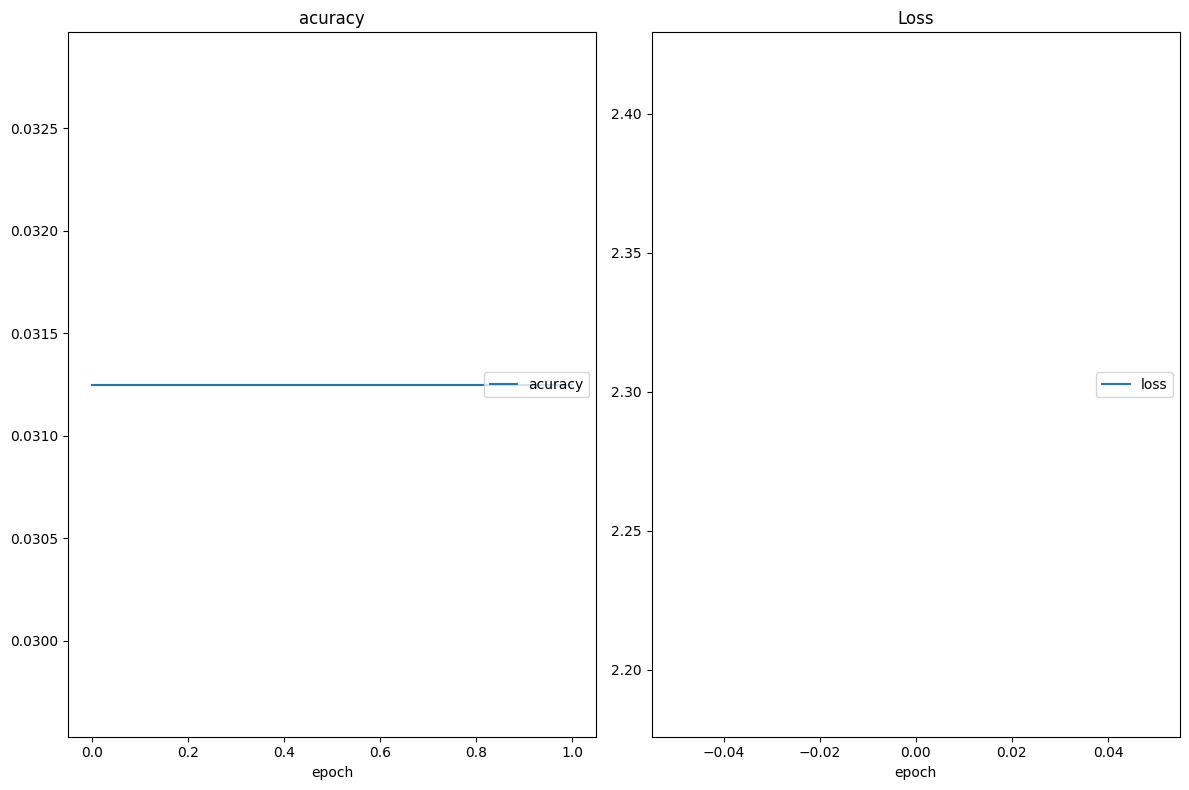

acuracy
	acuracy          	 (min:    0.031, max:    0.031, cur:    0.031)
Loss
	loss             	 (min:    2.303, max:    2.303, cur:      nan)


In [31]:
model.forward(train_loader, epochs=2)

In [212]:
model.cmp(c_model)

layer Inputs, size: loc 0, par 0
layer Inputs, cmp True
layer Dense_h1, size: loc 1, par 1
layer Dense_h1, cmp False
layer Dense_h2, size: loc 1, par 1
layer Dense_h2, cmp False
layer Softmax_out, size: loc 0, par 0
layer Softmax_out, cmp True


False

In [199]:
model.get_grads()[3][1]

TypeError: 'NoneType' object is not subscriptable

In [46]:
import numpy as np

In [57]:
a = np.ones(10)
delta = np.random.uniform(low=0, high=1, size=(10))
print(delta)
a.shape

[0.01766504 0.1177981  0.00631797 0.26399485 0.87546667 0.88055606
 0.29744105 0.63327045 0.48407139 0.33574919]


(10,)

In [58]:
np.dot(delta, a)

np.float64(3.9123307723796983)